# How the BERT Model works 

**(interesting but BERT is outdated)**

### Introduction

This Notebook trys to explain in detail, how the BERT Model works and how we use it to calculate our embeddings. It heavily debends on this Notebook (https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX)
First we import the modules required. You can safely ignore the warning stating "Some weights of .."

In [2]:
import pandas as pd
from transformers import BertModel, BertTokenizer
import torch
import warnings
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True) 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Users/br/Projects/IT-Ptojekt-Chatbot/daibl/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (in

### test tokenizer

##### tokenize sentence

Zum Start nehmen wir uns einen Beispielsatz und zerlegen ihn in Tokens.

In [4]:
test_sentence = "In der Bibliothek gibt es 40 Bücher zum Thema Animes"
test_sentence_tokens = tokenizer.tokenize(test_sentence)
print(*test_sentence_tokens)

in der bi ##bl ##iot ##he ##k gi ##bt es 40 bu ##cher zu ##m them ##a anime ##s


##### add spezial tokens

Als nächstes fügen wir die obligatorischen [CLS] und [SEP] tokens an den Anfang und das Ende 

In [5]:
test_sentence_tokens = ['[CLS]'] + test_sentence_tokens + ['[SEP]']
attention_mask = [1 if token != "[PAD]" else 0  for token in test_sentence_tokens]

##### convert to ids

Und dann berechnen dann die Token-IDs.

In [6]:
token_ids = tokenizer.convert_tokens_to_ids(test_sentence_tokens)
print(token_ids)

[101, 1999, 4315, 12170, 16558, 25185, 5369, 2243, 21025, 19279, 9686, 2871, 20934, 7474, 16950, 2213, 2068, 2050, 8750, 2015, 102]


##### Convert token ids to Tensor

Dann nehmen wir die Token IDs und füttern Sie dem BERT Model als Input. Das BERT Model ist ein dichtes neuronales Netzwerk mit 12 Schichten. Jede Schicht besteht dabei aus 768 verschiedenen Neuronen, die alle ein verschiedenen Wert annehmen können.

Wir benutzen hier auch die python Bibliothek torch. Diese bietet viele Möglichkeiten, Maschine Learning funktionalitäten einfach umzusetzen. In diesem Fall benutzen wir Tensoren. Tensoren kann man sich vorstellen als Listen von Listen. Eine Liste (=Array) ist eine eindimensionale Struktur. Wenn jedes Element der Liste eine weitere Liste beinhaltet, nennt man dies Matrix. Eine Matrix hat 2 Dimensionen. Wenn dann jedes Element dieser Matrix nochmal eine Liste ist, nennt man dies Tensor. Tensoren sind dann ein Überbegriff für n-dimensionale Datenstrukturen.

In diesem Fall erstellen wir einen Tensor aus einer Liste (token_ids). Der Tensor hat  die Dimension (len(token_ids),). Mit der funktion unsqueeze() können Wir einfach eine Dimension hinzufügen. Aus der Liste token_ids, wird eine Liste, die als erstes Element die Liste token_ids beinhaltet. Die Dimension ist jetzt (1, len(token_ids)). 

In [7]:
token_ids = torch.tensor(token_ids).unsqueeze(0)
attention_mask = torch.tensor(attention_mask).unsqueeze(0)

### Feed Tensor to Model

In [8]:
output = model(token_ids, attention_mask=attention_mask)
print(output[0].shape)

torch.Size([1, 21, 768])


##### analyse output

In der Output Variable speichern wir nun den output des BERT Models. Dieser Output ist sehr vielschichtig, also analysieren wir ihn etwas. 
Der Output besteht zunöchst aus 3 Elementen:
* output[0] - torch.Size([1, 31, 768])
* output[1] - torch.Size([1, 768])
* output[2] - list(torch.Size([1, 41, 768]))

Die ersten 2 Outputs stehen für die Ergebnisse des BERT Models die Default als Endwerte der letzten schicht (TODO überprüfen) stehen.

output[2] ist für die Berechnung der Embeddings jedoch am wichtigsten. Hierbei handelt es sich um die Hidden-States des Neuronalen Netzwerkes. 

output[2] besteht aus einer Liste mit 13 Elementen - 12 layer plus inout encoding
für jedes dieser Layer ist ein Tensor mit den Dimensionen (batch_size, Tokens, hidden_states) gespeichert.

In [9]:
hidden_states = output[2]
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 21
Number of hidden units: 768


##### visualising the Layer output

Das sind 409 344 verschiedene Werte um einen einzigen Satz zu repräsentieren!!!
Wir können uns an dieser Stelle auch einmal die Verteilung der hidden Werte in einem Bestimmten Layer für ein bestimmtes Token anschauen:

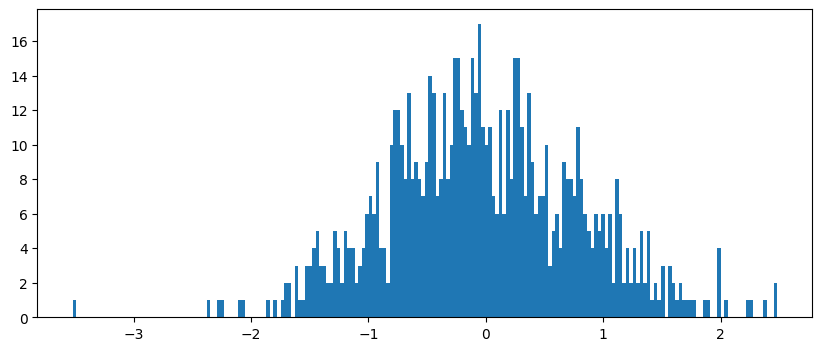

In [10]:
import matplotlib.pyplot as plt
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,4))
plt.hist(vec, bins=200)
plt.show()

##### Grouping the output

Die hidden_states sind gerade noch nch Layern gruppiert, aber es ist Sinnvoller, sie nach Tokens zu gruppieren. Die layer dimension ist gerade noch eine python Liste, deswegen fügen wir sie als 0 dimension einem Tensor hinzu. 

In [11]:
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings.size()

torch.Size([13, 1, 21, 768])

Als nächstes Entfernen wir die Batches dimension, da wir sowieso nur einen Satz haben:

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

Jetzt können wir die Dimensionen mithilfe von torchs permute vertauschen:

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

### Create Embedding

Das finale Ziel ist, ein einziges Embedding für diesen Satz zu erstellen. im Moment haben wir für jedes Token in jedem Layer ein Embedding. also 533 mal soviele wie wir eigentlich wollen.

Um dieses Problem zu lösen, gibt es verschiedene Möglichkeiten die verschiedenen Embeddings zu verbinden.

Eine Methode wäre, für jedes Token das 2. bis letzte Layer einfach nur zu mitteln

In [ ]:

layer_vecs = torch.mean(token_embeddings, dim=0)
print(layer_vecs.shape)
# Calculate the average of all 41 token vectors.
sentence_embedding = torch.mean(layer_vecs[2:], dim=0)
print(sentence_embedding.shape)

##### different approaches

Es gibt noch weitere Ansätze, z.B.:

nur das letzte layer
embed_1 = layer_vecs[12]

den durchschnitt aller layer
embed_2 = torch.mean(layer_vecs[2:], dim=0)

die Summe aller layer
embed_3 = layer_vecs[2:].sum(0)

die Summe der letzten 4 Layer
embed_4 = layer_vecs[-4:].sum(0) 

Die Letzten 4 Layer hintereinandergehängt
embed_5 = torch.cat([layer_vecs[i] for i in [-1,-2,-3,-4]], dim=0)

Die Entwickler des BERT Models haben selbst die verschiedenen Ansätze evaluiert und bei Ihnen war die concatenation der letzten 4 Layer am besten. Allerdings ist dies Aufgabenabhängig und die anderen Ansätze waren marginal schlechter. Die Evaluation für unser Problem muss nun noch erfolgen. 

### Evaluate Embeddings

In [1]:
import sys  
sys.path.append('../..')
from db_init import db_get_df, db_save_df
import json
import pandas as pd
from question_embedding import get_5_most_similar_documents
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm

/Users/br/Projects/IT-Ptojekt-Chatbot/daibl/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embeddings_df=db_get_df("chunk_embeddings")
# Convert back to lists.
queries = ["Was besagt das Fachhochschulgesetz?", 
             "Wo befindet sich die Mensa", 
             "Welche Professoren gibt es an der Technischen Hochschule Nürnberg?",
             "Gib mir alle Infos zum Studienstart",
             "Was gibt es Neues im Bezug auf Künstliche Intelligenz an der Hochschule?",
             "Themen für eine Batchelorarbeit",
             "Where is the Language office?",
             "Where can i find the Mensa",
             "Give me information on beginning of Semester",
             "How many professors are there at the TH?"]

most_similar_articles=""

for query in queries:
    most_similar_articles = get_5_most_similar_documents(query)
    print("prompt: ", query)
    print("most_similar_articles: \n"+most_similar_articles.to_markdown())

1908    0.171921
6789    0.171921
2070    0.171921
1669    0.171921
6046    0.171921
Name: distance, dtype: float64
prompt:  Was besagt das Fachhochschulgesetz?
most_similar_articles: 
|      | chunk_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            